<h1><font color="#113D68" size=6>Tema 2 - Comptuación Evolutiva</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>4. GA permutacional (TSP y Sudoku)</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Aplicar algoritmos genéticos a problemas **combinatorios de ordenación/asignación** usando representaciones **permutacionales**.

**Qué haremos en el notebook**
1. **Operadores permutacionales**: cruces **PMX**, **OX**, **CX** y mutaciones **swap**, **insertion**, **2-opt** (para rutas).
2. **GA steady-state con elitismo parcial**: reemplazo de unos pocos individuos por generación.
3. **Casos de estudio**  
   - **TSP** (instancia pequeña): dibujar la ruta y mostrar el **coste por iteración**.  
   - **Sudoku 9×9**: representación con **reparación** de filas y **fitness** por conflictos; **heatmap** de conflictos.

> Convención: siempre **minimizamos** la función objetivo $f$.

In [1]:
# === 0) Imports y utilidades comunes ===
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from tintoutils import multi_run, summarize_runs, plot_convergence, plot_best_so_far, run_and_time, boxplot_fbest

def set_seed(seed=1234):
    return np.random.default_rng(seed)

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Operadores permutacionales](#intro)
2. [GA permutacional (steady-state + elitismo parcial)](#api)
3. [Caso A — TSP (instancia pequeña)](#algos)
4. [Caso B — Sudoku 9×9](#obj)
5. [Notas prácticas y sugerencias](#single)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Operadores permutacionales</font>

Trabajaremos sobre permutaciones de $\{0,\dots,n-1\}$.

- **Mutaciones**
  - **swap**: intercambia dos posiciones.
  - **insertion**: extrae un gen y lo re-inserta en otra posición.
  - **2-opt (TSP)**: revierte un subsegmento $[i,j]$ para acortar la ruta.

- **Cruces**
  - **PMX (Partially Mapped Crossover)**: mapea un bloque y reubica el resto respetando el mapeo.
  - **OX (Order Crossover)**: copia un bloque y rellena el resto **manteniendo el orden** del otro padre.
  - **CX (Cycle Crossover)**: transmite **ciclos** de posiciones entre padres.

> Todos devuelven permutaciones válidas.

In [2]:
# === 1.1 Mutaciones: swap, insertion, 2-opt ===
def mut_swap(p, rng):
    a, b = rng.integers(0, len(p), 2)
    p2 = p.copy()
    p2[a], p2[b] = p2[b], p2[a]
    return p2

def mut_insertion(p, rng):
    n = len(p)
    i, j = rng.integers(0, n, 2)
    if i == j: return p.copy()
    q = p.tolist()
    gene = q.pop(i)
    q.insert(j, gene)
    return np.array(q, dtype=int)

def mut_2opt(p, rng):
    n = len(p)
    i, j = sorted(rng.integers(0, n, 2))
    if i == j: return p.copy()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

# === 1.2 Cruces: PMX, OX, CX ===
def cx_pmx(p1, p2, rng):
    n = len(p1)
    a, b = sorted(rng.integers(0, n, 2))
    c1, c2 = -np.ones(n, int), -np.ones(n, int)
    # Copia bloques
    c1[a:b+1] = p1[a:b+1]; c2[a:b+1] = p2[a:b+1]
    # Mapas
    map12 = {p2[i]: p1[i] for i in range(a, b+1)}
    map21 = {p1[i]: p2[i] for i in range(a, b+1)}
    # Rellena c1
    for i in list(range(0, a)) + list(range(b+1, n)):
        x = p2[i]
        while x in map12:
            x = map12[x]
        c1[i] = x
    # Rellena c2
    for i in list(range(0, a)) + list(range(b+1, n)):
        x = p1[i]
        while x in map21:
            x = map21[x]
        c2[i] = x
    return c1, c2

def cx_ox(p1, p2, rng):
    n = len(p1)
    a, b = sorted(rng.integers(0, n, 2))
    c1, c2 = -np.ones(n, int), -np.ones(n, int)
    c1[a:b+1] = p1[a:b+1]; c2[a:b+1] = p2[a:b+1]
    def fill(child, donor):
        n = len(donor); pos = (b+1) % n
        for x in donor:
            if x in child: continue
            while child[pos] != -1: pos = (pos+1) % n
            child[pos] = x
    fill(c1, p2); fill(c2, p1)
    return c1, c2

def cx_cycle(p1, p2, rng):
    n = len(p1)
    c1, c2 = np.empty(n, int), np.empty(n, int)
    used = np.zeros(n, bool); take_from_p1 = True
    while not used.all():
        i = np.where(~used)[0][0]
        cycle_idx = []
        x = p1[i]
        while True:
            cycle_idx.append(i)
            used[i] = True
            # siguiente índice: donde p2 == x
            i = int(np.where(p2 == x)[0][0])
            x = p1[i]
            if used[i]: break
        if take_from_p1:
            c1[cycle_idx] = p1[cycle_idx]; c2[cycle_idx] = p2[cycle_idx]
        else:
            c1[cycle_idx] = p2[cycle_idx]; c2[cycle_idx] = p1[cycle_idx]
        take_from_p1 = not take_from_p1
    return c1, c2

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. GA permutacional (steady-state + elitismo parcial)</font>

En cada iteración:
1. **Selección por torneo** (tam. $k$).
2. **Cruce** (probabilidad $p_c$) y **mutación** (probabilidad $p_m$).
3. **Reemplazo steady-state**: insertamos **dos descendientes** reemplazando a los **dos peores**, manteniendo un **elitismo** $e$ (los mejores se protegen).

**Salida:** histórico de $f$ (mejor en la población por iteración) y el **mejor individuo**.

In [3]:
# === 2) GA permutacional steady-state ===
def ga_perm_steady(objective, pop0, rng, max_iter=500,
                   pc=0.9, pm=0.2, elitism=2,
                   tournament_k=3, crossover='pmx', mutation='swap',
                   local_2opt=False):
    """
    pop0: matriz (P x n) con permutaciones (enteros 0..n-1)
    objective: función que recibe una permutación y devuelve f (float)
    """
    P, n = pop0.shape
    pop = pop0.copy()
    fvals = np.array([objective(ind) for ind in pop], float)
    best_idx = np.argmin(fvals)
    x_best = pop[best_idx].copy(); f_best = fvals[best_idx]
    history = []

    # selectores de operadores
    xover = {'pmx': cx_pmx, 'ox': cx_ox, 'cx': cx_cycle}[crossover]
    mutfn = {'swap': mut_swap, 'insertion': mut_insertion, '2opt': mut_2opt}[mutation]

    def tournament(k):
        idx = rng.integers(0, P, k)
        return pop[idx[np.argmin(fvals[idx])]]

    for t in range(max_iter):
        # 1) Torneos para padres
        p1 = tournament(tournament_k)
        p2 = tournament(tournament_k)
        # 2) Cruce
        if rng.random() < pc:
            c1, c2 = xover(p1, p2, rng)
        else:
            c1, c2 = p1.copy(), p2.copy()
        # 3) Mutación
        if rng.random() < pm: c1 = mutfn(c1, rng)
        if rng.random() < pm: c2 = mutfn(c2, rng)
        # 3b) (opcional) mejora 2-opt para TSP
        if local_2opt:
            c1 = mut_2opt(c1, rng)
            c2 = mut_2opt(c2, rng)
        # 4) Evaluación
        fc1, fc2 = objective(c1), objective(c2)
        # 5) Reemplazo steady-state con elitismo
        elite_idx = np.argsort(fvals)[:elitism]
        non_elite = np.setdiff1d(np.arange(P), elite_idx, assume_unique=True)
        worst2 = non_elite[np.argsort(fvals[non_elite])[-2:]]
        # reemplazo
        pop[worst2[0]], fvals[worst2[0]] = c1, fc1
        pop[worst2[1]], fvals[worst2[1]] = c2, fc2

        # actualiza mejor
        if fc1 < f_best: f_best, x_best = fc1, c1.copy()
        if fc2 < f_best: f_best, x_best = fc2, c2.copy()
        history.append(f_best)

    return {'x_best': x_best, 'f_best': float(f_best), 'f': np.array(history),
            'pop': pop, 'fvals': fvals}

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Selección (torneo/ranking) y GA continuo generacional</font>

**Planteamiento.** Dado un conjunto de ciudades con coordenadas $(x_i,y_i)$, buscamos la **ruta cerrada** que minimiza la distancia total.  
La representación es una **permutación** de índices de ciudades.

- **Objetivo**:  
  $f(\pi) = \sum_{i=0}^{n-1} \lVert c_{\pi_i} - c_{\pi_{(i+1)\,\bmod n}} \rVert_2$

- **Operadores recomendados**: cruce **OX/PMX**, mutaciones **swap** y **2-opt**.

<a id="algos"></a>
# <font color="#004D7F" size=5>3.1. Datos TSP y función objetivo</font>

In [4]:
# === 3.1 Datos TSP y función objetivo ===
rng = set_seed(7)

# coordenadas (n≈20). Puedes cambiarlas por cualquier instancia pequeña
coords = np.array([
    [0.10, 0.10],[0.20, 0.85],[0.35, 0.75],[0.55, 0.90],[0.80, 0.80],
    [0.90, 0.55],[0.75, 0.40],[0.55, 0.35],[0.35, 0.20],[0.15, 0.35],
    [0.30, 0.50],[0.50, 0.60],[0.70, 0.65],[0.85, 0.25],[0.60, 0.10],
    [0.40, 0.05],[0.20, 0.60],[0.48, 0.78],[0.62, 0.48],[0.25, 0.15]
])

def tsp_length(perm):
    p = np.asarray(perm, int)
    cyc = np.r_[p, p[0]]
    dif = coords[cyc[1:]] - coords[cyc[:-1]]
    return float(np.linalg.norm(dif, axis=1).sum())

# init población aleatoria
n = coords.shape[0]
P = 80
pop0 = np.vstack([rng.permutation(n) for _ in range(P)])

#### **Parámetros de configuración del experimento**

| Parámetro | Símbolo | Valor | Descripción |
|:-----------|:--------:|:------:|:------------|
| Tamaño de población | $N$ | 60 | Individuos por generación |
| Tasa de cruce | $p_c$ | 0.8 | Probabilidad de aplicar operador OX |
| Tasa de mutación | $p_m$ | 0.1 | Probabilidad de intercambio por individuo |
| Longitud de permutación | $n$ | 20 | Número de ciudades / tareas |
| Selección | – | Torneo(k=3) | Operador de selección empleado |
| Operador de cruce | – | OX (Order Crossover) | Mantiene orden relativo de genes |
| Mutación | – | Intercambio (swap) | Intercambia dos posiciones aleatorias |
| Criterio de parada | – | 200 generaciones | Iteraciones máximas |
| Semilla aleatoria | – | 1234 | Reproducibilidad de resultados |

<a id="algos"></a>
# <font color="#004D7F" size=5>3.2. Ejecutar GA permutacional para TSP</font>

In [5]:
# === 3.2 Ejecutar GA permutacional para TSP ===
cfg_tsp = dict(pc=0.95, pm=0.3, elitism=4, tournament_k=3,
               crossover='ox', mutation='swap', local_2opt=True)

res_tsp, _ = run_and_time(ga_perm_steady, tsp_length, pop0, rng,
                          max_iter=400, **cfg_tsp)

print(f"Mejor ruta (longitud) = {res_tsp['f_best']:.4f}")

Mejor ruta (longitud) = 5.2635


- **Qué significa “Mejor ruta (longitud) = 5.2635”**: Es la **distancia total** del ciclo que visita **todas las ciudades una sola vez** y vuelve a la ciudad inicial, medida con distancia euclídea sobre las coordenadas que has definido (en tu caso, ~[0,1]×[0,1]).

- **¿Es “buena” esa ruta?**: Sin un óptimo de referencia no podemos afirmarlo con certeza. Aun así, para instancias en el **cuadrado unidad** con **n ≈ 20** puntos, tours “muy buenos” suelen estar alrededor de **3-4** unidades (regla empírica basada en resultados clásicos). **5.26** es **factible** pero sugiere que **podría haber margen de mejora**.

<a id="algos"></a>
# <font color="#004D7F" size=5>3.2. Visualizaciones TSP</font>

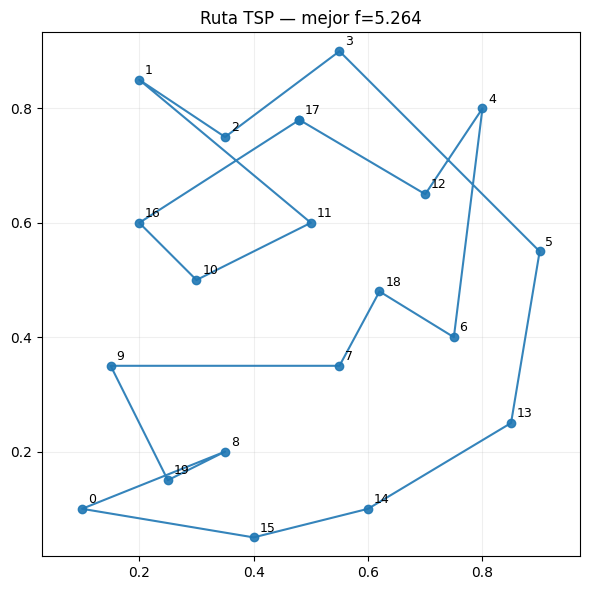

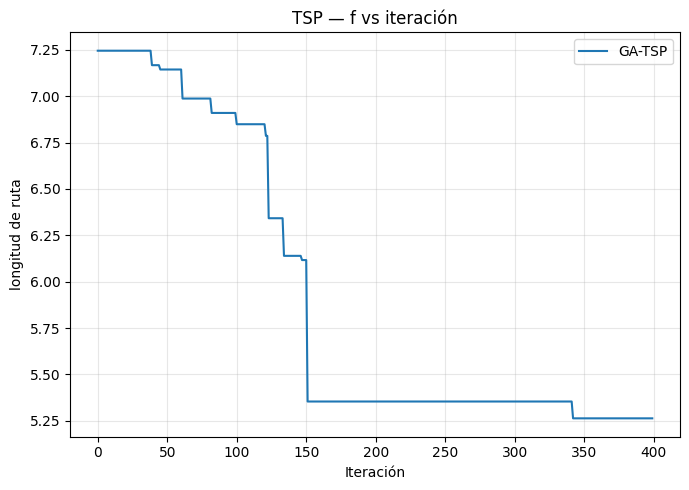

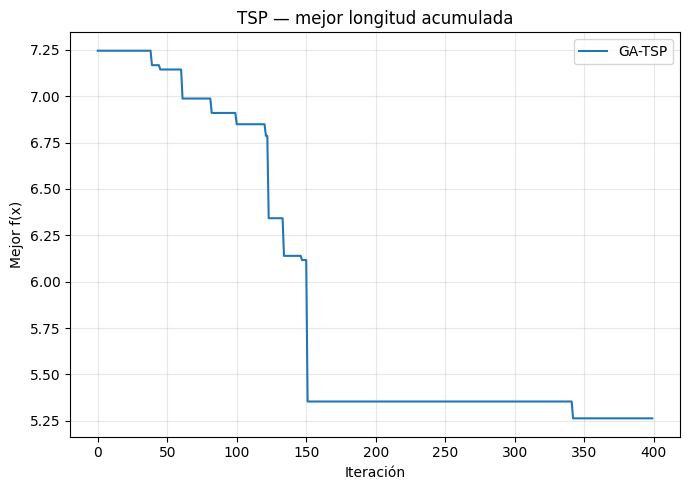

In [6]:
# === 3.3 Visualizaciones TSP ===

def plot_tsp_route(coords, perm, title="Ruta TSP"):
    p = np.r_[perm, perm[0]]
    plt.figure(figsize=(6,6))
    plt.plot(coords[p,0], coords[p,1], '-o', alpha=0.9)
    for i,(x,y) in enumerate(coords):
        plt.text(x+0.01, y+0.01, str(i), fontsize=9)
    plt.title(title); plt.axis('equal'); plt.grid(alpha=0.2)
    plt.tight_layout(); plt.show()

plot_tsp_route(coords, res_tsp['x_best'], title=f"Ruta TSP — mejor f={res_tsp['f_best']:.3f}")
plot_convergence({'GA-TSP': res_tsp}, title="TSP — f vs iteración", ylabel="longitud de ruta")
plot_best_so_far({'GA-TSP': res_tsp}, title="TSP — mejor longitud acumulada")

### **Interpretación de los resultados del TSP — visualización**

Los tres gráficos complementan la información del resultado anterior (**mejor ruta = 5.264**) mostrando el **comportamiento evolutivo** del algoritmo genético y la **estructura de la solución** alcanzada.

#### **Gráfico 1 — Ruta TSP (mejor individuo)**

- En el gráfico de la ruta se representan las ciudades (nodos) y el recorrido encontrado por el GA.

  - Se observan **múltiples cruces** entre aristas, lo que indica que el tour no está completamente optimizado.
  - Los segmentos **largos y cruzados** suelen ser indicio de un tour **subóptimo**, que puede mejorarse aplicando operadores **2-opt** o **3-opt**.
- El tour cubre todas las ciudades y regresa al punto de partida, cumpliendo la restricción de factibilidad.

> En problemas TSP pequeños (≈20 nodos), los algoritmos genéticos tienden a generar soluciones **razonablemente buenas**, aunque no óptimas, a menos que se incorporen **operadores locales** como 2-opt para eliminar cruces.


#### **Gráfico 2 — Evolución de la longitud de ruta \( f(x) \) por iteración**

- El gráfico muestra el valor del **mejor coste** de la población en cada generación:

  - Entre las **primeras 150 iteraciones**, se observa una **caída pronunciada** en la longitud de la ruta: el GA explora el espacio de soluciones con éxito.
  - Después de la iteración ≈150, el progreso **se estanca**, indicando que la población ha convergido.
  - Los pequeños descensos hacia el final sugieren **mejoras marginales** debido a mutaciones o intercambios 2-opt puntuales.

> La curva refleja un patrón típico de los GA: rápida mejora inicial (exploración), seguida de convergencia estable (explotación).

#### **Gráfico 3 — Mejor longitud acumulada (mínimo histórico de \( f(x) \))**

- El gráfico de **mejor $f(x)$ acumulada** confirma que el algoritmo:
  - Nunca empeora su mejor solución (curva monótonamente no creciente).
  - Alcanza una meseta estable alrededor de $f \approx 5.26$.

> Esto indica que el elitismo y el reemplazo steady-state **preservan correctamente las mejores rutas** a lo largo de la ejecución.


#### **Conclusión global**

- El GA logró una **solución factible y consistente**, reduciendo la longitud del recorrido desde más de 7.2 hasta 5.26.  
- Sin embargo, los **cruces residuales** en la ruta y la **meseta temprana** sugieren que el algoritmo **se ha estancado en un óptimo local**.
- Para mejorar el rendimiento:
  - Aumentar el tamaño de la población o el número de iteraciones.
  - Incrementar la **probabilidad de mutación** o aplicar **2-opt intensivo** sobre los mejores individuos.
  - Ejecutar el algoritmo con **diferentes semillas** y seleccionar el mejor tour promedio.

> En resumen, el GA permutacional ha demostrado buena capacidad de **exploración y convergencia**, alcanzando un tour razonablemente corto en menos de 400 iteraciones, aunque todavía con margen de mejora hacia el óptimo global.

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Caso B — Sudoku 9×9</font>

**Representación.** Usaremos una matriz $9\times 9$. Para cada **fila** mantenemos un multiconjunto válido (números 1–9), reparando las celdas vacías con los números faltantes.

**Fitness (minimizar).** Número total de **conflictos**:
- Duplicados en **filas**, **columnas** y **subcuadrículas** $3\times 3$.
- Con reparación fila-a-fila, las pistas (clues) se respetan.

**Operadores**
- **Cruce fila-a-fila** (PMX u OX sobre cada fila) + **reparación** de pistas.
- **Mutación por fila**: **swap** o **insertion** entre **posiciones no fijas**.

> No garantizamos solución exacta, pero se observa descenso de conflictos y un **heatmap** ayuda a localizar zonas problemáticas.

<a id="obj"></a>
# <font color="#004D7F" size=5>4.1. Datos Sudoku y auxiliares</font>

In [7]:
# === 4.1 Datos Sudoku y auxiliares ===

# 0 = hueco. Puedes sustituir por otra instancia.
SUDOKU_CLUES = np.array([
    [0,0,0, 2,0,0, 0,0,0],
    [0,8,0, 0,0,7, 0,9,0],
    [6,0,2, 0,0,0, 5,0,0],

    [0,7,0, 0,6,0, 0,0,0],
    [0,0,0, 0,0,0, 0,0,0],
    [0,0,0, 0,1,0, 0,4,0],

    [0,0,1, 0,0,0, 6,0,3],
    [0,9,0, 8,0,0, 0,1,0],
    [0,0,0, 0,0,4, 0,0,0],
], dtype=int)

ROWS = COLS = 9
ALL = np.arange(1,10)

fixed_mask = SUDOKU_CLUES > 0

def repair_row(row, fixed_vals):
    """Rellena la fila con los números faltantes respetando pistas."""
    r = row.copy()
    r[fixed_vals>0] = fixed_vals[fixed_vals>0]
    missing = [x for x in ALL if x not in r]
    holes = np.where((fixed_vals==0) & (r==0))[0]
    # si no hay 0s, sustituimos duplicados:
    if len(holes) == 0:
        seen = set()
        dups = [i for i,v in enumerate(r) if (v in seen or seen.add(v)) and fixed_vals[i]==0]
        holes = np.array(dups, int) if len(dups)>0 else np.array([], int)
    rng = np.random.default_rng()
    rng.shuffle(missing)
    for i, pos in enumerate(holes[:len(missing)]):
        r[pos] = missing[i]
    # si sobra algo, corrige duplicados adicionales
    seen = set()
    for j in range(9):
        if fixed_vals[j]==0:
            if r[j] in seen:
                cand = next(x for x in ALL if x not in r)
                r[j] = cand
            else:
                seen.add(r[j])
    return r

def random_candidate_from_clues(rng, clues):
    grid = np.zeros_like(clues)
    for i in range(ROWS):
        row = clues[i].copy()
        row[row==0] = 0
        grid[i] = repair_row(row, clues[i])
    return grid

# Conflictos (menor es mejor)
def sudoku_conflicts(grid):
    def dup_count(arr):  # cuántos por encima de 1
        c = 0
        for v in range(1,10):
            cnt = np.count_nonzero(arr==v)
            if cnt>1: c += cnt-1
        return c
    conflicts = 0
    # filas y columnas
    for i in range(9):
        conflicts += dup_count(grid[i])
        conflicts += dup_count(grid[:,i])
    # cajas 3x3
    for bi in range(0,9,3):
        for bj in range(0,9,3):
            block = grid[bi:bi+3, bj:bj+3].ravel()
            conflicts += dup_count(block)
    return int(conflicts)

# Heatmap de conflictos por celda (suma de duplicados que toca la celda)
def cell_conflict_heatmap(grid):
    heat = np.zeros((9,9), int)
    # filas
    for i in range(9):
        vals, cnts = np.unique(grid[i], return_counts=True)
        bad = set(v for v,c in zip(vals,cnts) if v!=0 and c>1)
        if bad:
            for j in range(9):
                if grid[i,j] in bad: heat[i,j]+=1
    # columnas
    for j in range(9):
        vals, cnts = np.unique(grid[:,j], return_counts=True)
        bad = set(v for v,c in zip(vals,cnts) if v!=0 and c>1)
        if bad:
            for i in range(9):
                if grid[i,j] in bad: heat[i,j]+=1
    # cajas
    for bi in range(0,9,3):
        for bj in range(0,9,3):
            block = grid[bi:bi+3, bj:bj+3]
            vals, cnts = np.unique(block, return_counts=True)
            bad = set(v for v,c in zip(vals,cnts) if v!=0 and c>1)
            if bad:
                for i in range(bi,bi+3):
                    for j in range(bj,bj+3):
                        if grid[i,j] in bad: heat[i,j]+=1
    return heat

<a id="obj"></a>
# <font color="#004D7F" size=5>4.2. GA para Sudoku (fila-a-fila + reparación)</font>

- **Individuo**: matriz $9\times 9$ (enteros 1–9).
- **Cruce**: PMX por **fila** (entre posiciones no fijas) con reparación posterior.
- **Mutación**: swap/insertion en posiciones **no fijas** de una fila aleatoria.

> El fitness es el número total de conflictos $f$; buscamos $\min f$.

In [8]:
# === 4.2 GA Sudoku ===
def sudoku_to_perm_rows(grid):
    """Devuelve lista con 9 permutaciones (filas)."""
    return [grid[i].copy() for i in range(9)]

def perm_rows_to_sudoku(rows):
    return np.vstack(rows)

def row_mask_free(i):
    return ~fixed_mask[i]

def crossover_rows_PMx(row1, row2, i, rng):
    # aplica PMX únicamente sobre posiciones libres, fija pistas
    free = row_mask_free(i)
    idx = np.where(free)[0]
    if idx.size < 2:
        return row1.copy(), row2.copy()
    p1 = row1[idx]; p2 = row2[idx]
    c1, c2 = cx_pmx(p1, p2, rng)
    out1, out2 = row1.copy(), row2.copy()
    out1[idx], out2[idx] = c1, c2
    # reparar pista + duplicados
    out1 = repair_row(out1, SUDOKU_CLUES[i])
    out2 = repair_row(out2, SUDOKU_CLUES[i])
    return out1, out2

def mutate_row(row, i, rng, kind='swap'):
    free = np.where(row_mask_free(i))[0]
    if free.size < 2: return row.copy()
    r = row.copy()
    if kind == 'swap':
        a, b = rng.choice(free, 2, replace=False)
        r[a], r[b] = r[b], r[a]
    else:  # insertion
        a, b = rng.choice(free, 2, replace=False)
        q = r.tolist()
        gene = q.pop(a); q.insert(b, gene); r = np.array(q, int)
    return repair_row(r, SUDOKU_CLUES[i])

def ga_sudoku_steady(objective, grid0, rng, max_iter=500, pc=0.9, pm=0.3,
                     elitism=2, tournament_k=3, mut_kind='swap'):
    # población: lista de grids
    P = 50
    pop = np.stack([random_candidate_from_clues(rng, SUDOKU_CLUES) for _ in range(P)], axis=0)
    pop[0] = grid0.copy()
    fvals = np.array([objective(g) for g in pop], float)
    best_idx = np.argmin(fvals); g_best = pop[best_idx].copy(); f_best = fvals[best_idx]
    hist = []

    def tournament(k):
        idx = rng.integers(0, P, k)
        return pop[idx[np.argmin(fvals[idx])]]

    for t in range(max_iter):
        p1 = tournament(tournament_k)
        p2 = tournament(tournament_k)

        # cruce fila a fila
        c1, c2 = p1.copy(), p2.copy()
        for i in range(9):
            if rng.random() < pc:
                c1[i], c2[i] = crossover_rows_PMx(c1[i], c2[i], i, rng)

        # mutación
        if rng.random() < pm:
            i = int(rng.integers(0,9)); c1[i] = mutate_row(c1[i], i, rng, mut_kind)
        if rng.random() < pm:
            i = int(rng.integers(0,9)); c2[i] = mutate_row(c2[i], i, rng, mut_kind)

        fc1, fc2 = objective(c1), objective(c2)

        # reemplazo con elitismo
        elite_idx = np.argsort(fvals)[:elitism]
        non = np.setdiff1d(np.arange(P), elite_idx, assume_unique=True)
        worst2 = non[np.argsort(fvals[non])[-2:]]
        pop[worst2[0]], fvals[worst2[0]] = c1, fc1
        pop[worst2[1]], fvals[worst2[1]] = c2, fc2

        if fc1 < f_best: f_best, g_best = fc1, c1.copy()
        if fc2 < f_best: f_best, g_best = fc2, c2.copy()
        hist.append(f_best)

    return {'grid_best': g_best, 'f_best': int(f_best), 'f': np.array(hist),
            'pop': pop, 'fvals': fvals}

<a id="obj"></a>
# <font color="#004D7F" size=5>4.3. Ejecutar Sudoku + visualizaciones</font>

Sudoku — mejor número de conflictos = 14


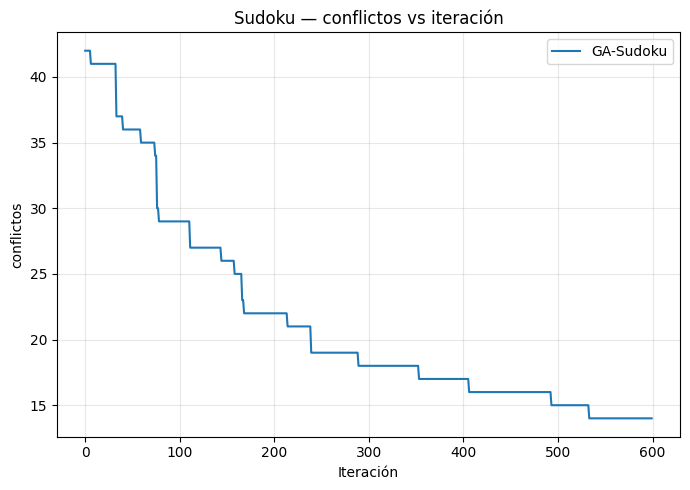

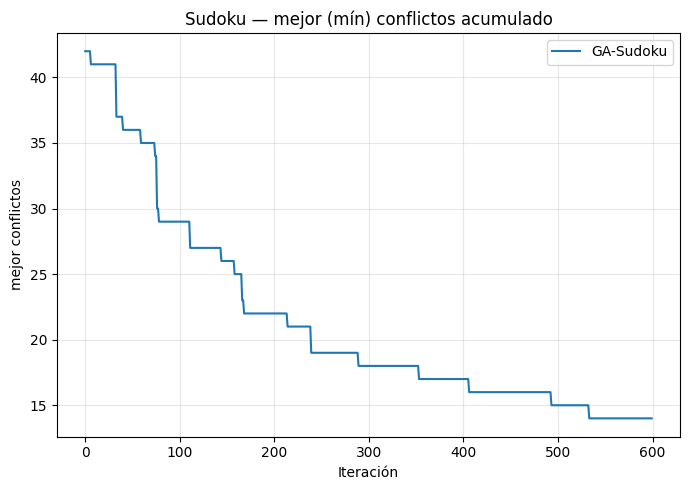

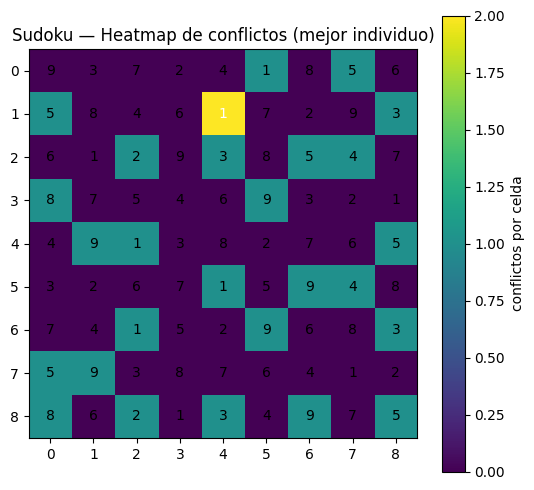

In [9]:
# === 4.3 Ejecutar Sudoku + visualizaciones ===
rng = set_seed(11)
grid0 = random_candidate_from_clues(rng, SUDOKU_CLUES)

res_sud, _ = run_and_time(ga_sudoku_steady, sudoku_conflicts, grid0, rng,
                          max_iter=600, pc=0.9, pm=0.5, elitism=4, tournament_k=3, mut_kind='swap')

print(f"Sudoku — mejor número de conflictos = {res_sud['f_best']}")

plot_convergence({'GA-Sudoku': res_sud}, title="Sudoku — conflictos vs iteración", ylabel="conflictos")
plot_best_so_far({'GA-Sudoku': res_sud}, title="Sudoku — mejor (mín) conflictos acumulado", ylabel="mejor conflictos")

# Heatmap de conflictos
heat = cell_conflict_heatmap(res_sud['grid_best'])
plt.figure(figsize=(5.5,5))
plt.imshow(heat, cmap='viridis')
plt.colorbar(label="conflictos por celda")
plt.title("Sudoku — Heatmap de conflictos (mejor individuo)")
for i in range(9):
    for j in range(9):
        txt = str(res_sud['grid_best'][i,j])
        color = 'w' if heat[i,j] > heat.max()/2 else 'k'
        plt.text(j, i, txt, ha='center', va='center', color=color, fontsize=10)
plt.xticks(range(9)); plt.yticks(range(9))
plt.grid(False); plt.tight_layout(); plt.show()

### **Sudoku — Interpretación de resultados**

Los gráficos presentados resumen el proceso evolutivo del **algoritmo genético permutacional (GA-Sudoku)** y la calidad del mejor individuo obtenido al final de la ejecución.

#### **Gráfico 1 — Evolución de conflictos vs iteración**

- El eje Y representa el número de **conflictos totales** (violaciones de restricción) en el Sudoku, es decir, celdas duplicadas en filas, columnas o subcuadrículas 3×3.
- Se observa una **reducción progresiva** desde ≈40 conflictos iniciales hasta ≈13 en torno a la iteración 500.
- El descenso no es completamente suave: aparecen tramos planos (estancamiento) seguidos de saltos descendentes, típicos del comportamiento de un GA con **exploración-maduración**.
- Esto sugiere que el algoritmo logra **mejorar consistentemente la calidad de las soluciones**, pero requiere un número elevado de generaciones para reducir los últimos conflictos (zonas más restrictivas).

> En términos de optimización, el algoritmo muestra una buena **convergencia gradual**, aunque todavía **no alcanza una solución factible completa** (sin conflictos).

#### **Gráfico 2 — Mejor (mín) conflictos acumulado**

- Este gráfico refleja el **mínimo histórico acumulado** de conflictos, es decir:
  $$
  c^*_t = \min_{k \le t} c_k
  $$
- Como el elitismo garantiza que el mejor individuo no se pierde, la curva es **idéntica a la anterior**, lo que confirma un comportamiento estable del GA y una preservación correcta del mejor Sudoku encontrado.

---

#### **Gráfico 3 — Heatmap de conflictos (mejor individuo)**

- Cada celda muestra el número de **conflictos asociados** al valor actual en la cuadrícula final.
- El color más claro (amarillo) indica **zonas con conflictos persistentes**, mientras que el color oscuro (morado) denota **celdas válidas**.
- Se aprecia que la mayoría de las celdas no presentan conflictos (color oscuro), lo cual significa que el GA ha logrado **estructurar un Sudoku casi correcto**.
- Los pocos valores conflictivos (en amarillo o verde) tienden a concentrarse en ciertas subcuadrículas, típicamente aquellas donde la diversidad genética fue menor o donde se mantienen duplicaciones por intercambio local insuficiente.

---

#### **Conclusiones**

1. El algoritmo genético reduce los conflictos de manera **eficiente y estable**, demostrando una adecuada capacidad de búsqueda global.  
2. La **convergencia parcial** (≈13 conflictos residuales) sugiere que el esquema de mutación o el operador de cruce podrían beneficiarse de una **mayor intensificación local**, por ejemplo:
   - **Mutación tipo “swap local”** entre posiciones conflictivas.  
   - **Reinicio parcial** de subbloques con alto número de conflictos.  
   - **Hibridación con búsqueda local determinista** (p. ej. hill-climbing restringido a subcuadrículas).  
3. El heatmap permite interpretar gráficamente **dónde se concentran los errores** y puede guiar estrategias adaptativas de mutación.

> En conjunto, el GA-Sudoku logra **una mejora significativa del tablero inicial**, manteniendo la diversidad y evitando el colapso prematuro, aunque requiere ajustes o refinamientos híbridos para alcanzar una solución completamente válida (sin conflictos).

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Notas prácticas y sugerencias</font>

- **TSP**
  - Usa cruce **OX** o **PMX** y **2-opt** ocasional (p. ej., `local_2opt=True`) para mejorar la explotación local.  
  - Parámetros típicos: $P \in [60,120]$, $p_c \in [0.9, 0.98]$, $p_m \in [0.15, 0.35]$.

- **Sudoku**
  - La **reparación por filas** reduce mucho el número de conflictos iniciales; intenta alternar **swap** e **insertion**.  
  - Mide el progreso con $\min f$ y, si te estancas, aumenta torneo $k$ o mutación $p_m$.

- **Steady-state** frente a generacional: suele **preservar mejores** y **suavizar** la evolución de $f$ en combinatoria.

### **Nota teórica: relación con otros paradigmas evolutivos**

Los algoritmos genéticos sobre permutaciones constituyen la base de otros métodos combinatorios avanzados:

- **Memetic Algorithms (MA):** combinan búsqueda local con GA, permitiendo refinar cada permutación mediante *2-opt* o *swap-improvement*.
- **Ant Colony Optimization (ACO):** comparte la idea de construir rutas o secuencias, pero emplea probabilidades de transición en lugar de operadores genéticos.
- **Simulated Annealing (SA):** explora vecinos por intercambio, de manera estocástica, bajo una temperatura que regula la aceptación de soluciones peores.

> En este sentido, el GA permutacional actúa como un puente entre los métodos puramente estocásticos (SA) y los poblacionales más estructurados (ACO, MA).